In [2]:
%load_ext autoreload
%autoreload 2

# Data exploration using "dask" and a cluster on AWS.

## Get credentials from .aws/credentials

In the general case, if you only have one set of credentials on aws try the "default" profile

In [3]:
AWS_PROFILE = "mats"

In [4]:
import boto3

session = boto3.Session(profile_name=AWS_PROFILE)
credentials = session.get_credentials()

##  Spin up the cluster using a Fargate Cluster

The cluster shuts down automatically after 20 minutes of inactivity. Use the link to access the dask dashboard.

In [5]:
N_WORKERS = 5

In [6]:
from dask_cloudprovider.aws import FargateCluster
from dask.distributed import Client

# Setup Fargate cluster
cluster = FargateCluster(
    region_name="eu-north-1",
    scheduler_timeout="20 minutes",
    image="daskdev/dask:2024.9.1-py3.12",
    n_workers=N_WORKERS,
    environment={"EXTRA_PIP_PACKAGES": "dask zarr s3fs pyarray xarray"},
    aws_access_key_id=credentials.access_key,
    aws_secret_access_key=credentials.secret_key,
)
cluster.dashboard_link

/usr/lib/python3.12/contextlib.py:144: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources on AWS. Hang tight! 
  next(self.gen)


'http://13.60.33.8:8787/status'

### Initiate dask using the cluster

In [7]:
client = Client(cluster)

/home/joakim/.virtual_envs/dask_cluster/lib/python3.12/site-packages/distributed/client.py:1606: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+---------+
| Package | Client         | Scheduler      | Workers |
+---------+----------------+----------------+---------+
| python  | 3.12.3.final.0 | 3.12.6.final.0 | None    |
+---------+----------------+----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


## Start exploring the dataset

In this example I want to generate a schedule plot.

I only read the columns from the dataset that I need to use, to limit the transfer from s3 to the workers.

In [8]:
DATASET = "s3://ops-payload-level1b-v0.9"

In [9]:
vars = [
    "schedule_name",
    "EXPDate",
]

Initialize the dataset as a Dask DataFrame that can be found on AWS S3 as parquet files.

In [10]:
import dask.dataframe as dd
import s3fs

fs = s3fs.S3FileSystem(
    key=credentials.access_key, secret=credentials.secret_key
)
df = dd.read_parquet(
    DATASET, filesystem=fs, columns=vars
)


### Task definitions

I want to create a timeseries of schedule_name for the entire dataset to find when schedule_name changes.

In [11]:
df_sorted = df.sort_values(["EXPDate"])
df_sorted["mode_change"] = (
    df_sorted["schedule_name"] != df_sorted["schedule_name"].shift()
).astype("float")

df_sorted["group_id"] = df_sorted["mode_change"].cumsum()
groups = df_sorted.groupby(["group_id", "schedule_name"])

Send task to the cluster

In [12]:
result = groups.agg({'EXPDate':['min','max']}).compute()


# Barplot

Create a timetable like barplot 

/tmp/ipykernel_844525/990121454.py:9: UserWarning: Discarding nonzero nanoseconds in conversion.
  row["EXPDate"]["max"].to_pydatetime() - row["EXPDate"]["min"].to_pydatetime()
/tmp/ipykernel_844525/990121454.py:11: UserWarning: Discarding nonzero nanoseconds in conversion.
  start = row["EXPDate"]["min"].to_pydatetime()


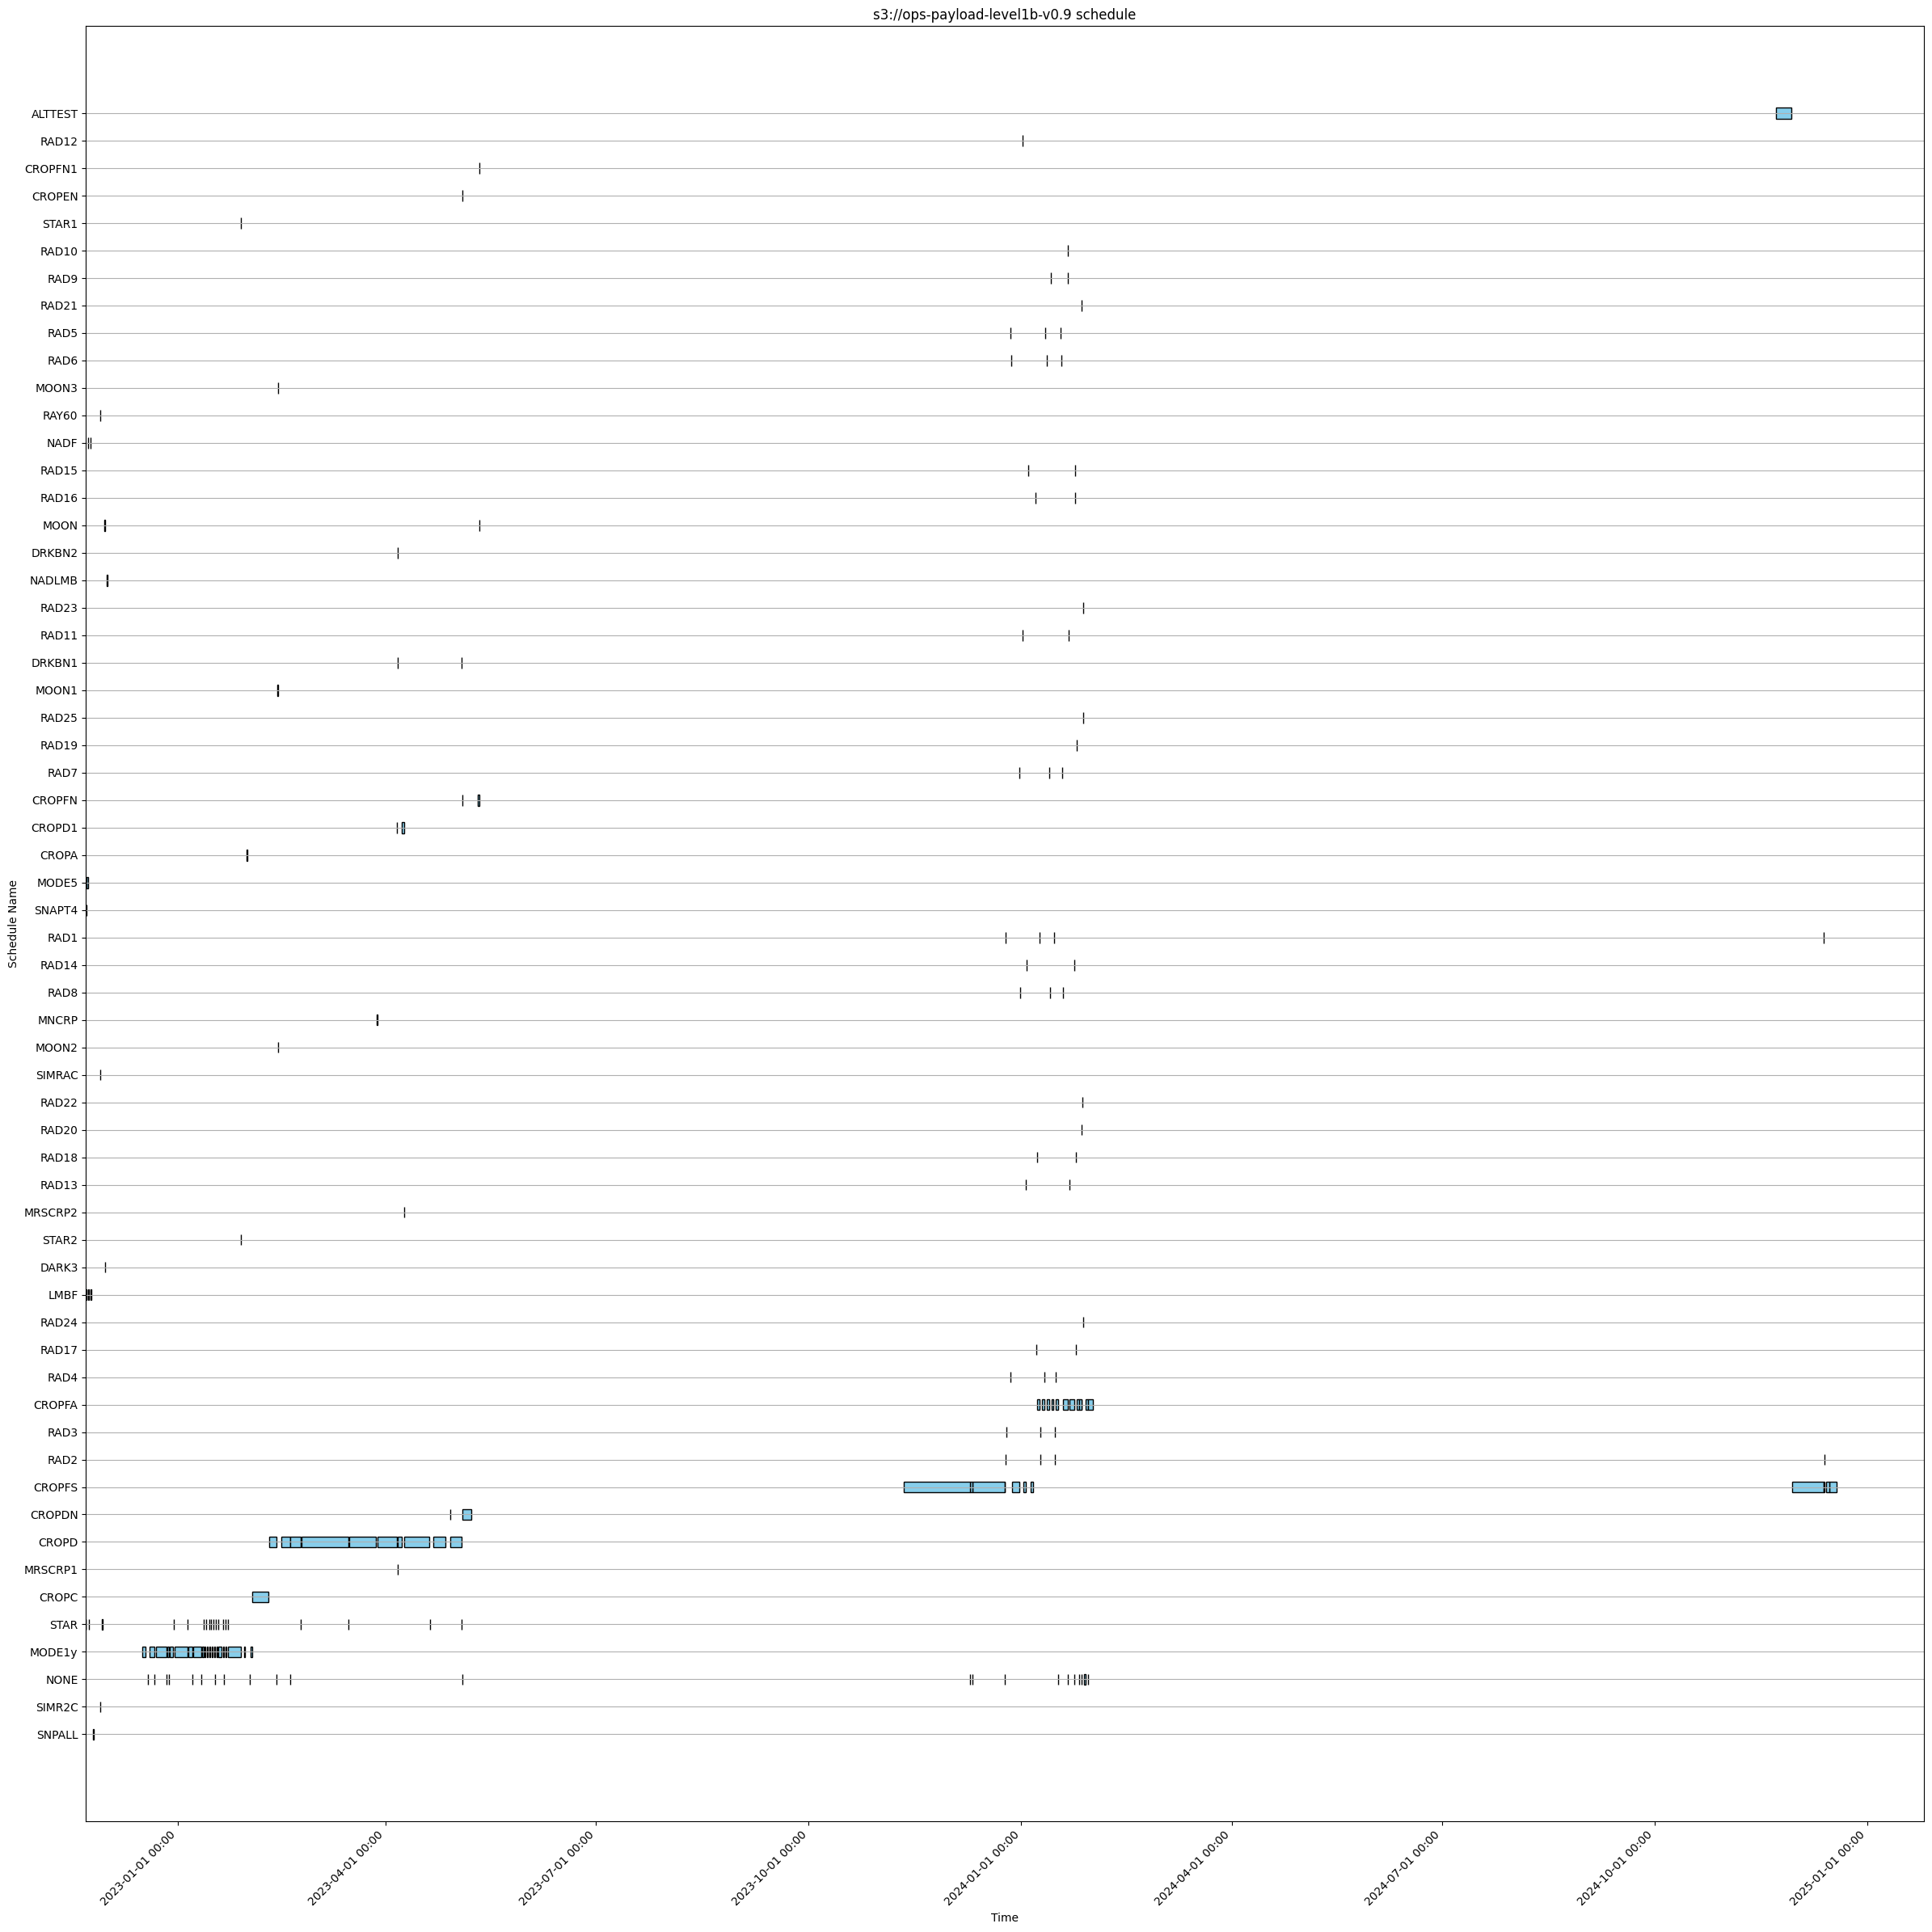

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(24, 24))

for idx, row in result.iterrows():
    label = idx[1]
    length = (
        row["EXPDate"]["max"].to_pydatetime() - row["EXPDate"]["min"].to_pydatetime()
    )
    start = row["EXPDate"]["min"].to_pydatetime()
    ax.barh(label, length, left=start, height=0.4, color="skyblue", edgecolor="black")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.xticks(rotation=45, ha="right")

ax.set_ylabel("Schedule Name")
ax.set_xlabel("Time")
ax.set_title(f"{DATASET} schedule")
ax.grid(axis="y")

plt.tight_layout()

close client

In [14]:
client.close()

tear down the cluster

In [15]:
cluster.close()